In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage

from src.datasets import BiosensorDataset, create_datasets
from src.unet.unet_model import UNet
from src.train import train_model
from src.evaluate import evaluate
from src.utils import *

c:\Users\wittd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

data_path = 'C:/onlab_git/Onlab/data_with_centers/'
checkpoint_dir = 'unet-checkpoints'
train_percent = 0.495
test_percent = 0.30
batch_size = 4
bio_len = 8
mask_size = 80*4 # if input scaling is True, this is the size of the input image

train_dataset, val_dataset, test_dataset = create_datasets(data_path, train_percent, bool, test_percent=test_percent, 
                                biosensor_length=bio_len, mask_size=mask_size, augment=True, 
                                dilation=0, input_scaling=True, upscale_mode='nearest') # nearest bilinear bicubic

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = UNet(n_channels=bio_len, n_classes=1)
model = model.to(device)

Using device cuda


In [3]:
try:
    train_model(
        model,
        device,
        train_loader,
        val_loader,
        learning_rate=0.01,
        epochs=10,
        checkpoint_dir=checkpoint_dir,
        amp=True,
        wandb_logging=False
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

Starting training:
        Epochs:          10
        Batch size:      4
        Learning rate:   0.01
        Training size:   80
        Validation size: 35
        Device:          cuda
        Mixed Precision: True
        Dilatation:      0
    


Epoch 1/10: 100%|██████████| 80/80 [00:16<00:00,  4.93img/s, loss (batch)=0.852]


Validation Dice score: 0.0951191857457161, Detection rate: 0.16650501131587456
Checkpoint 1 saved!


Epoch 2/10: 100%|██████████| 80/80 [00:15<00:00,  5.17img/s, loss (batch)=0.936]


Validation Dice score: 0.11226960271596909, Detection rate: 0.11445198836081474
Checkpoint 2 saved!


Epoch 3/10: 100%|██████████| 80/80 [00:15<00:00,  5.13img/s, loss (batch)=0.724]


Validation Dice score: 0.025534117594361305, Detection rate: 0.0316844487552538
Checkpoint 3 saved!


Epoch 4/10: 100%|██████████| 80/80 [00:15<00:00,  5.14img/s, loss (batch)=0.833]


Validation Dice score: 0.015279993414878845, Detection rate: 0.02780472033624313
Checkpoint 4 saved!


Epoch 5/10: 100%|██████████| 80/80 [00:15<00:00,  5.20img/s, loss (batch)=0.759]


Validation Dice score: 0.07538803666830063, Detection rate: 0.11477529906239897
Checkpoint 5 saved!


Epoch 6/10: 100%|██████████| 80/80 [00:15<00:00,  5.17img/s, loss (batch)=0.887]


Validation Dice score: 0.1429627686738968, Detection rate: 0.13870029097963144
Checkpoint 6 saved!


Epoch 7/10: 100%|██████████| 80/80 [00:15<00:00,  5.13img/s, loss (batch)=0.788]


Validation Dice score: 0.11188147962093353, Detection rate: 0.12318137730358875
Checkpoint 7 saved!


Epoch 8/10: 100%|██████████| 80/80 [00:15<00:00,  5.14img/s, loss (batch)=0.824]


Validation Dice score: 0.1443016231060028, Detection rate: 0.14193339799547364
Checkpoint 8 saved!


Epoch 9/10: 100%|██████████| 80/80 [00:15<00:00,  5.18img/s, loss (batch)=0.735]


Validation Dice score: 0.20211872458457947, Detection rate: 0.20691884901390237
Checkpoint 9 saved!


Epoch 10/10: 100%|██████████| 80/80 [00:15<00:00,  5.13img/s, loss (batch)=0.775]

Validation Dice score: 0.2155422568321228, Detection rate: 0.26414484319430975
Checkpoint 10 saved!


In [11]:
# from torchsummary import summary
# Print the model summary
# summary(model, input_size=(bio_len, mask_size, mask_size))

# Load the checkpoint
checkpoint = torch.load("unet-checkpoints/checkpoint_epoch4.pth")
# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')
# Load the state dictionary into the model
model.load_state_dict(checkpoint)
# Move the model to the device
model = model.to(device)

In [5]:
val_dice_score, val_detection_rate = evaluate(model, val_loader, device)
dice_score, detection_rate = evaluate(model, test_loader, device)
print(f'Validation dice score: {val_dice_score}, Detection rate: {val_detection_rate}')
print(f'Validation dice score: {dice_score}, Detection rate: {detection_rate}')

Validation dice score: 0.2266436219215393, Detection rate: 0.2796637568703524
Validation dice score: 0.20258337259292603, Detection rate: 0.282798833819242


In [15]:
# Saving the best model for production
# model = UNet(n_channels=8, n_classes=1)
# checkpoint = torch.load("checkpoints/checkpoint_8_4_85.pth")
# lr = checkpoint.pop('learning_rate')
# model.load_state_dict(checkpoint)

# torch.jit.script(model).save('saved_models/unet_len8.pth')

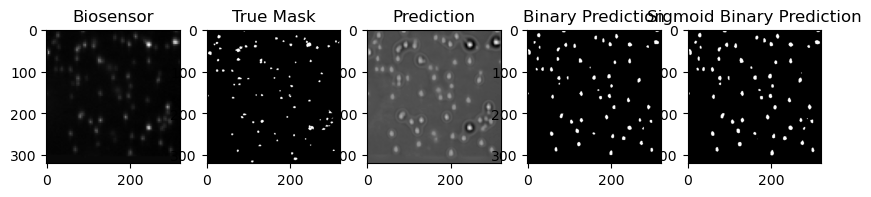

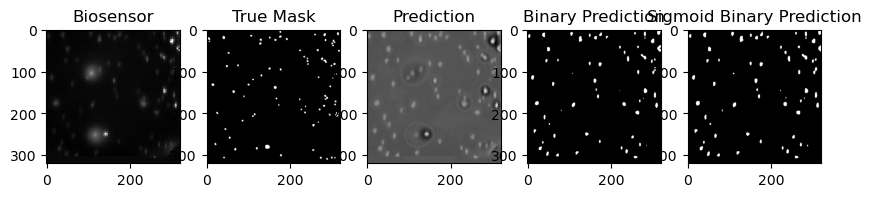

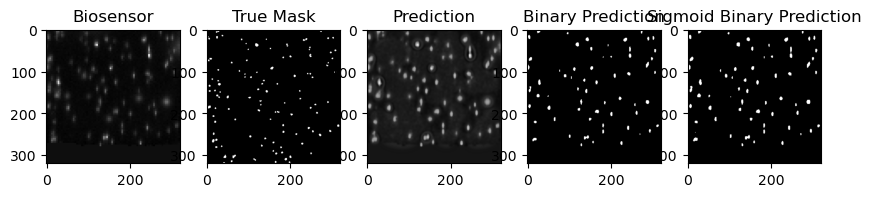

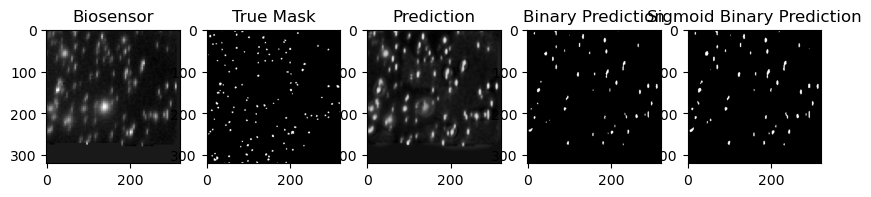

In [4]:
# Load a batch of data and labels
loader_iter = iter(test_loader)
data, labels = next(loader_iter)
data, labels = next(loader_iter)
data, labels = next(loader_iter)

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Get the predictions
predictions = model(data)

sigmoid_predictions = (torch.nn.functional.sigmoid(predictions) > 0.5)
sigmoid_predictions = sigmoid_predictions.cpu().detach().numpy()

# Move the predictions and labels to the CPU and convert them to numpy arrays
predictions = predictions.cpu().detach().numpy()
binary_predictions = (predictions > 0.5).astype(np.uint8)

labels = labels.cpu().numpy()

# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 50))
    
    plt.subplot(1, 5, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Biosensor')
    
    plt.subplot(1, 5, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('True Mask')
    
    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 5, 4)
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='gray')
    plt.title('Binary Prediction')

    plt.subplot(1, 5, 5)
    plt.imshow(np.squeeze(sigmoid_predictions[i]), cmap='gray')
    plt.title('Sigmoid Binary Prediction')
    
    plt.show()

In [ ]:
# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Data')
    
    plt.subplot(1, 3, 2)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.imshow(np.squeeze(labels[i]), cmap='jet', alpha=0.5)
    plt.title('Data with Label overlay')
    
    plt.subplot(1, 3, 3)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Data with Binary Prediction overlay')
    
    plt.show()

In [ ]:
# Plot the label and the prediction
for i in range(len(labels)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Label with Prediction overlay')
    
    plt.show()

In [17]:
label, detected = pos_pixels(model, test_loader, device, threshold=0.5)
print(label, detected)

9485 8665


In [32]:
cell_detection_rate, total, detected = cell_detection_skimage(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')
cell_detection_rate, total, detected = cell_detection_skimage(model, test_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.8149231894659839, total cells: 2734, detected cells: 2228
Cell detection rate: 0.7850824766913699, total cells: 4183, detected cells: 3284


In [38]:
# It has sigmoid activation, so the results a bit better
cell_detection_rate, total, detected = cell_detection_scipy(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')
cell_detection_rate, total, detected = cell_detection_scipy(model, test_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.8269934162399415, total cells: 2734, detected cells: 2261
Cell detection rate: 0.7946449916327994, total cells: 4183, detected cells: 3324
